# Anwendung und Vergleich von Machine Learning und Deep Learning Algorithmen zur Vorhersage von COVID-19 Kennzahlen

## Regression
Mit einer Regression werden mit unabhängigen Variabeln $x^{n}$ abhängige Variabeln $y^{n}$ beschrieben. Die unabhängigen Variabeln sind numerisch. 
Die lineare Regression ist die einfachste Art der Regression. Sie geht davon aus dass die Beziehung linear ist. 
Bei der Polynomregression werden die Polynome von x verwendet: ${x}$, $x^{2}$, $x^{3}$...

## Imports

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import plotly.graph_objs as go
from ipywidgets import interact

%matplotlib inline

# Konfiguration
Auf Windows funtktioniert eine relative Pfadangabe nicht. Darum untenstehende Konfiguration des absoluten Pfades wo das Projekt abgelegt ist.


In [124]:
#Path to raw_data -> change it localy
root_path =  "C:/Users/marco/IdeaProjects/ml-corona/"

## Laden der Daten

In [125]:
# Load the data from disk
full_dataset = np.load(root_path +'preprocessing/dataset.npy')

# Polynomiale Regression
## Normalisieren und Aufteilen

In [126]:
#Prepare the X and y data
X_all = pd.DataFrame(data=full_dataset)
y_all = X_all.copy()
#remove cases at position 0
X_all.pop(0)
print(f"X all shape {X_all.shape}")
#remove all other than cases
y_all = y_all.drop(y_all.columns[[1,2,3,4,5,6,7,8,9,10]], axis=1) 
print(f"y all shape {y_all.shape}")

# Split data in training and test set
num_datapoints = X_all.shape[0]
num_training = int(num_datapoints*0.7)

X_train, X_test = X_all[:num_training], X_all[num_training:]
y_train, y_test = y_all[:num_training], y_all[num_training:]

# Verify the shapes of train and test
# Scale the datasets using RobutScaler (as this scaler scales the data according to the quantile range (default: Inter Quartile Range IQR))
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
y_train = pd.DataFrame(scaler.fit_transform(y_train))
y_test = pd.DataFrame(scaler.fit_transform(y_test))
print(f"X train shape {X_train.shape}")
print(f"y train shape {y_train.shape}")
print(f"X test shape {X_test.shape}")
print(f"y test shape {y_test.shape}")

print(X_train.tail(5))


X all shape (661, 10)
y all shape (661, 1)
X train shape (462, 10)
y train shape (462, 1)
X test shape (199, 10)
y test shape (199, 1)
            0         1         2    3    4    5    6         7         8  \
457  0.918514  0.142857  0.990296  0.0  0.0  0.0  0.0  0.261364  0.160284   
458  0.959074  0.000000  0.965602  0.0  0.0  0.0  0.0  0.268939  0.152899   
459  0.884834  0.000000  1.000000  0.0  0.0  0.0  0.0  0.261364  0.145788   
460  0.480820  0.000000  0.486990  0.0  0.0  0.0  0.0  0.232955  0.126368   
461  0.234896  0.000000  0.202283  0.0  0.0  0.0  0.0  0.202652  0.117341   

            9  
457  0.018519  
458  0.027778  
459  0.018519  
460  0.037037  
461  0.000000  


## Polynom finden mit TimeSeriesSplit
Loop über alle Polynome um den Score und die Abweichung herauszufinden. Die Daten werden historisch aufgeteilt mit TimeSeriesSplit in 5 Teile.

### zu testende Polynomen

In [127]:
polynoms = [2,3,4,5,6,7,8,9]

Polynom 2 mean squared error :            9962580197122207744
Polynom 3 mean squared error :        43017357549784824545280
Polynom 4 mean squared error :                     2870231132
Polynom 5 mean squared error :                    17998003486
Polynom 6 mean squared error :               3664938053094146
Polynom 7 mean squared error :           28603429567336722432
Polynom 8 mean squared error :         2406500936609965277184
Polynom 9 mean squared error :        14004587336084339294208


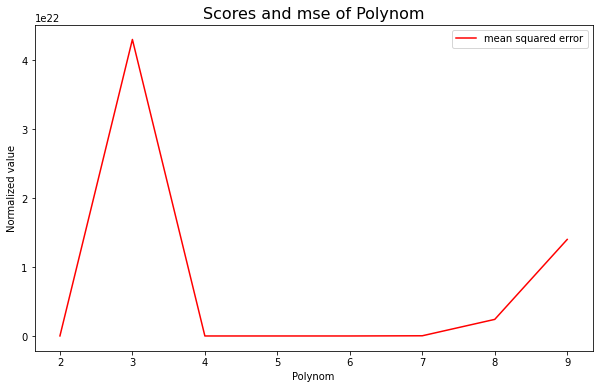

In [128]:
# Loop over polynoms
mse_list = []
for i in polynoms:
    poly = PolynomialFeatures(i)
    model = LinearRegression()
    #Split the time series
    splits = TimeSeriesSplit(n_splits=5)
    mse_split_list = []
    for train_index, test_index in splits.split(X_train):
        #Train
        X_train_split, X_test_split = X_train.iloc[train_index],X_train.iloc[test_index]
        y_train_split,y_test_split = y_train.iloc[train_index],y_train.iloc[test_index]
        poly_features_train = poly.fit_transform(X_train_split)
        model.fit(poly_features_train, y_train_split)

        #Test
        poly_features_test = poly.fit_transform(X_test_split)
        y_predicted = model.predict(poly_features_test)
        mse_split = mean_squared_error(y_test_split, y_predicted)
        mse_split_list.append(mse_split)

    mse = sum(mse_split_list)/len(mse_split_list)
    print(f"Polynom {i} mean squared error : {mse:>30.0f}")
    mse_list.append(mse)

plt.figure(figsize=(10, 6))
plt.title("Scores and mse of Polynom", size=16)
plt.plot(polynoms, mse_list, c="red", label='mean squared error')
plt.xlabel("Polynom")
plt.ylabel("Normalized value")
plt.legend()
plt.show()

# Polynome evaluieren über ganzen Zeitraum
Ohne Timesplit Evaluation des Mean Square Errors.

Polynom  1 mean squared error :              0.01972
Polynom  2 mean squared error :              0.06509
Polynom  3 mean squared error :             39.91870
Polynom  4 mean squared error :            622.21814
Polynom  5 mean squared error :     1894582115.47428
Polynom  6 mean squared error :      715211584.51479
Polynom  7 mean squared error :     1916598879.24958
Polynom  8 mean squared error : 985726669479290.87500
Polynom  9 mean squared error : 5775634670373305344.00000


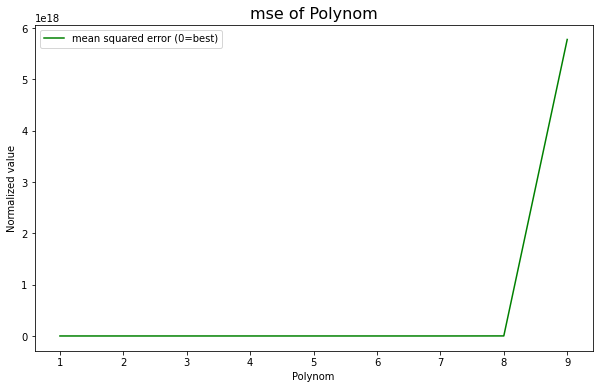

In [136]:
# Loop over polynoms
polynoms = [1,2,3,4,5,6,7,8,9]
mse_list = []
for i in polynoms:
    poly = PolynomialFeatures(i)
    model = LinearRegression()
    poly_features_train = poly.fit_transform(X_train)
    model.fit(poly_features_train, y_train)

    #Test
    poly_features_test = poly.fit_transform(X_test)
    y_predicted = model.predict(poly_features_test)
    mse = mean_squared_error(y_test, y_predicted)
    mse_list.append(mse)
    print(f"Polynom {i:2d} mean squared error : {mse:>20.5f}")

plt.figure(figsize=(10, 6))
plt.title("mse of Polynom", size=16)
plt.plot(polynoms, mse_list, c="green", label='mean squared error (0=best)')
plt.xlabel("Polynom")
plt.ylabel("Normalized value")
plt.legend()
plt.show()

## Training

In [ ]:
polynom = 1

In [130]:
poly = PolynomialFeatures(polynom)
model = LinearRegression()
poly_features = poly.fit_transform(X_train)
model.fit(poly_features, y_train)   

LinearRegression()

## Evaluation
Evaluierung mit den Testdaten

mean squared error 0.01971863559763515


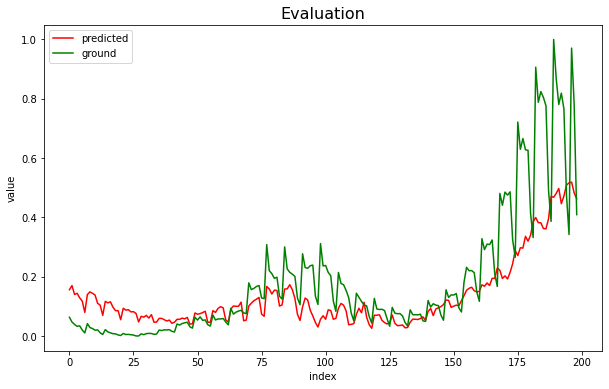

In [131]:

X_test_transformed = poly.fit_transform(X_test)
y_predicted = model.predict(X_test_transformed)
poly_reg_rmse = mean_squared_error(y_test, y_predicted)
print(f"mean squared error {poly_reg_rmse}")

plt.figure(figsize=(10, 6))
plt.title("Evaluation", size=16)
plt.plot(y_test.index, y_predicted, c="red", label='predicted')
plt.plot(y_test.index, y_test[0], c="green", label='ground')
plt.xlabel("index")
plt.ylabel("value")
plt.legend()
plt.show()